# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
!pip3 install dask
!pip install graphviz
!pip install folium
!pip install gpxpy
!pip install gensim
!pip install prettytable
!pip install sklearn
!pip install dask[complete]
!pip3 install plotly 
!pip install dash==0.35.1  # The core dash backend
!pip install dash-html-components==0.13.4  # HTML components
!pip install dash-core-components==0.42.1  # Supercharged components
!pip3 install dash-table==3.1.11
!pip install scikit-plot

In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
con = sqlite3.connect(r'/content/drive/My Drive/database.sqlite') 

In [5]:
filteredData = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)
#filteredData=filteredData.iloc[0:3000,:]
#filteredData.shape               
dfScore=filteredData['Score']

def convertPositiveNegative(x):
    if x < 3:
        return 'negative'
    return 'positive'
dfPositiveNegative=dfScore.map(convertPositiveNegative)


filteredData['Score']=dfPositiveNegative
print(filteredData.head(5))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:
As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
sorted_data=filteredData.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [8]:
(final['Id'].size*1.0)/(filteredData['Id'].size*1.0)*100

69.25890143662969

In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape
print(final.head(5))

            Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   
138690                     1                       1  positive  1076025600   
138691                     3                       4  positive  1018396800   

                                           Summary  \
138706                   E

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
                
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [44]:
final['CleanedText']=final_string

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
final=final.sort_values(by='Time')

In [0]:
final_new=final

In [47]:
final=final.iloc[0:60000,:]
final.shape

(60000, 12)

In [0]:
final['Score_num']=final.Score.map({'positive':1, 'negative':0})
Y=final['Score_num']

In [0]:
X_train=final.iloc[0:5000]
Y_train=final['Score_num'].iloc[0:5000]

In [0]:
X_train_decode=X_train

# tfidF

In [0]:
count_vect = TfidfVectorizer(ngram_range=(1,1)) #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)

In [0]:
arr=count_vect.idf_[0:2000]

In [0]:
word2tfidf = dict(zip(count_vect.get_feature_names(), count_vect.idf_))

In [0]:
import operator
word2tfidf_sorted=sorted(word2tfidf,reverse = True,key=operator.itemgetter(1))

In [0]:
word2tfidf_sorted_2000=word2tfidf_sorted[0:2000]

In [57]:
X_train_decode['CleanedText']=X_train['CleanedText'].str.decode("utf-8")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
co_occ = np.zeros((2000,2000))
for row in X_train['CleanedText'].values:
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        length=len(words_in_row)
        if word in word2tfidf_sorted_2000:
            for j in range(max(index-5,0),min(index+6,length)):
                
                if words_in_row[j] in word2tfidf_sorted_2000:
                    co_occ[word2tfidf_sorted_2000.index(word),word2tfidf_sorted_2000.index(words_in_row[j])] += 1
                else:
                    pass
        else:
            pass

In [0]:
svd = TruncatedSVD(n_components = 1500)
svd_model = svd.fit_transform(co_occ)

In [0]:
var_percentage = svd.explained_variance_ / np.sum(svd.explained_variance_);
cum_var = np.cumsum(var_percentage)


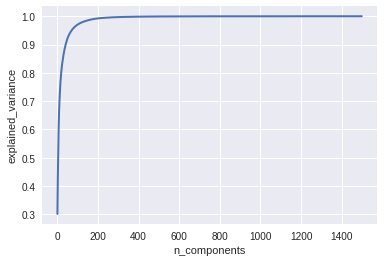

In [75]:
plt.figure(figsize=(6, 4))
plt.plot(cum_var, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('explained_variance')
plt.show()

In [0]:
kmeans = KMeans(n_clusters = 15)

In [84]:
kmeans.fit(svd_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [0]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

In [0]:
lebels=kmeans.labels_

Cluster 0:


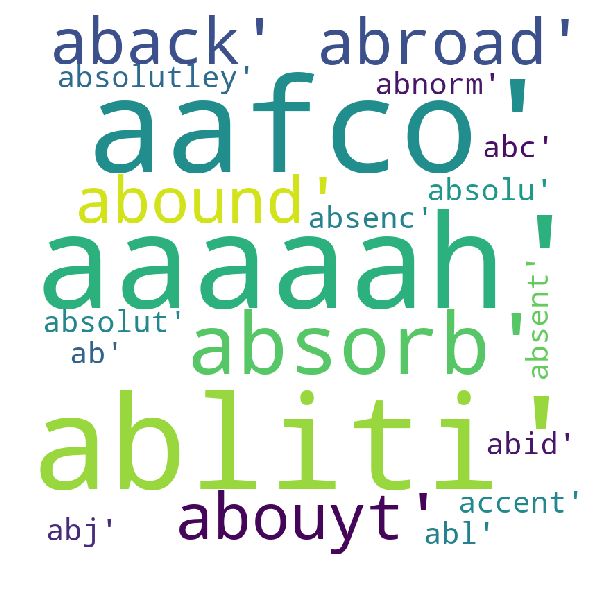

Cluster 1:


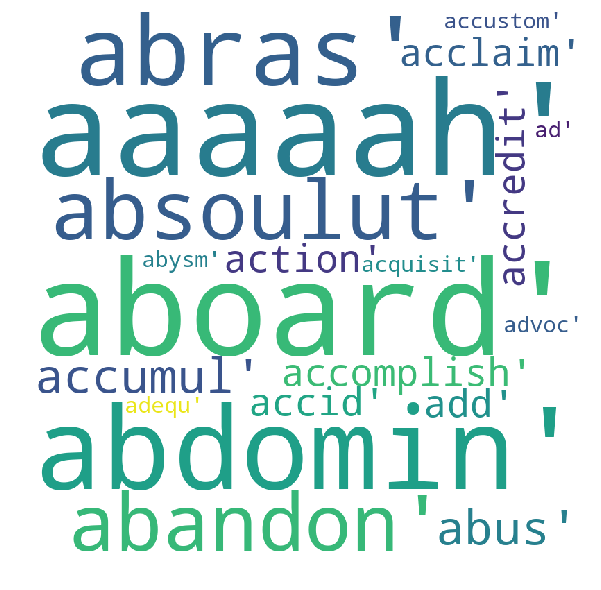

Cluster 2:


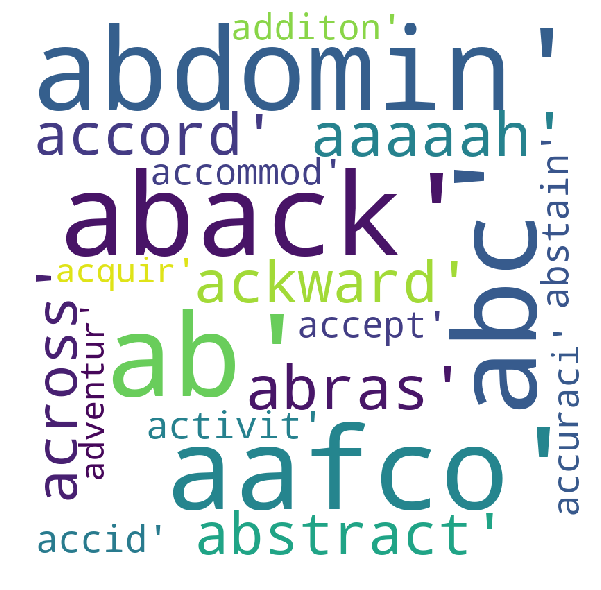

Cluster 3:


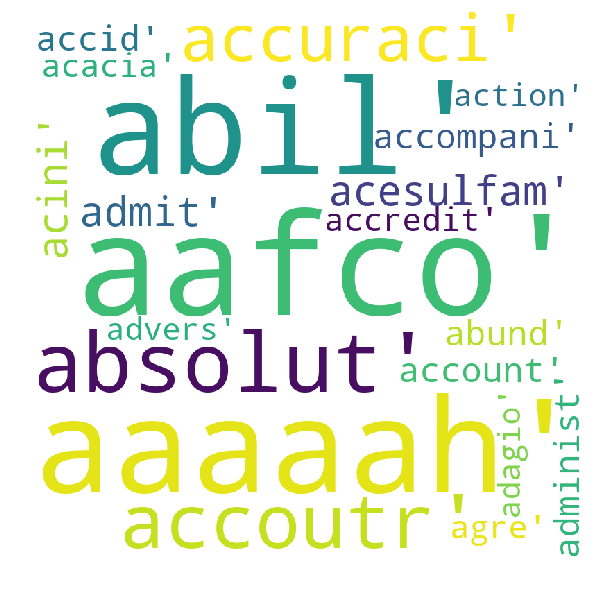

Cluster 4:


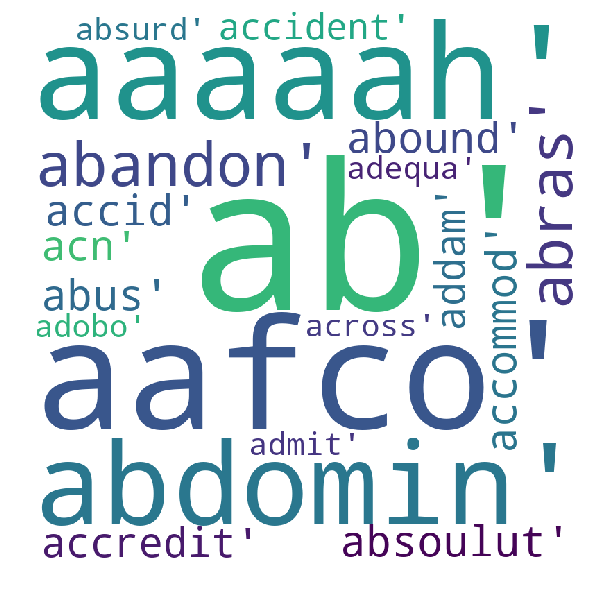

Cluster 5:


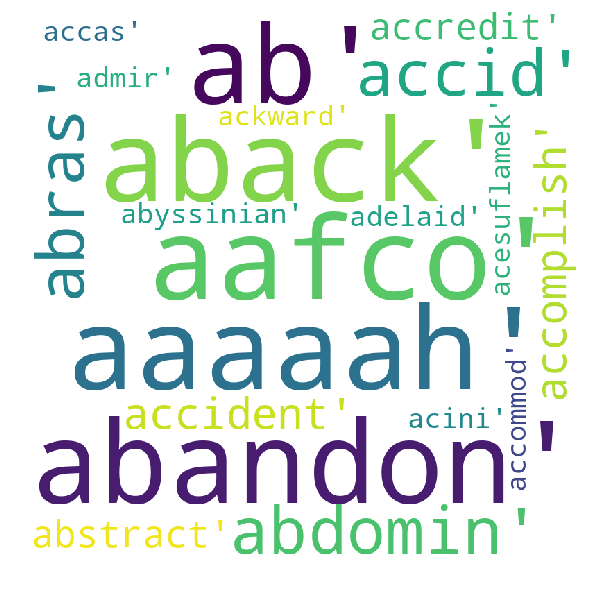

Cluster 6:


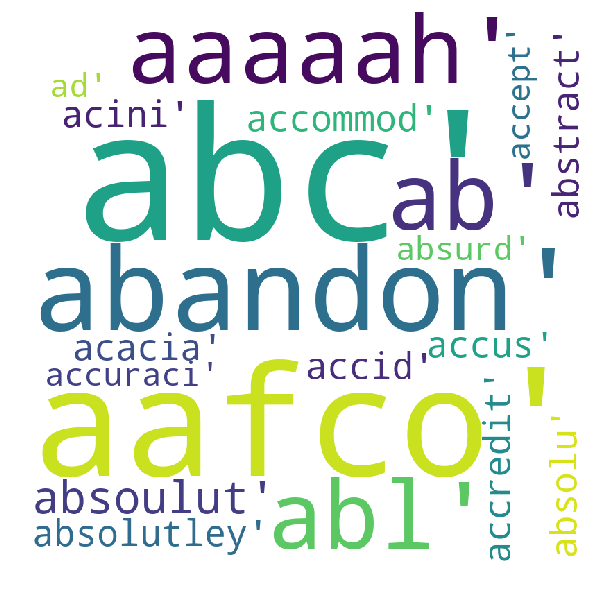

Cluster 7:


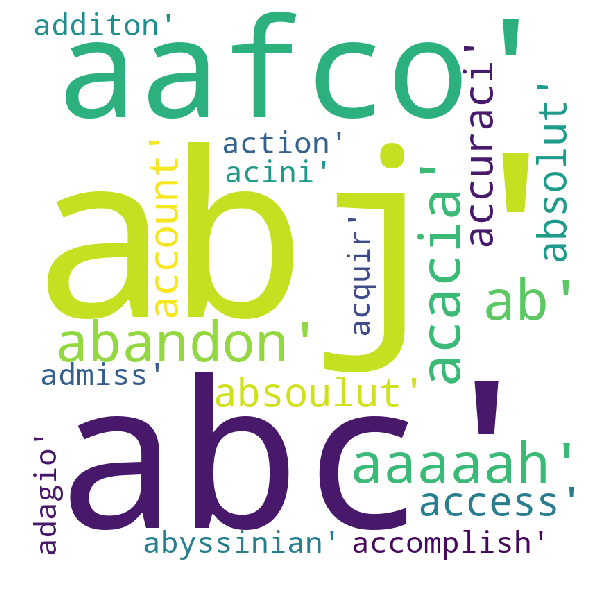

Cluster 8:


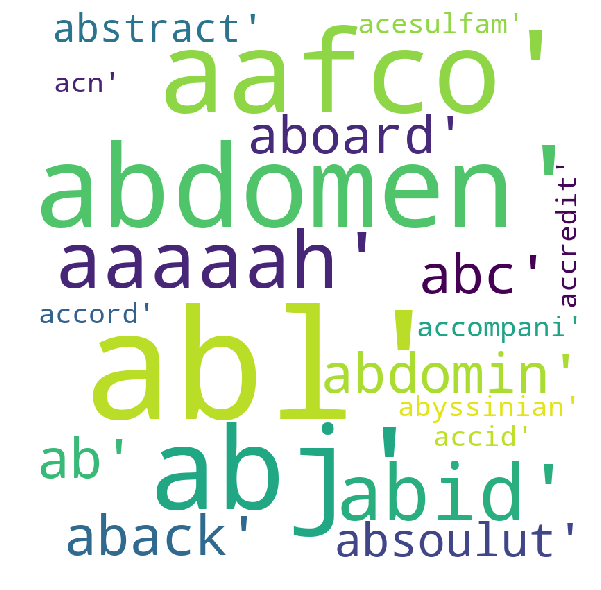

Cluster 9:


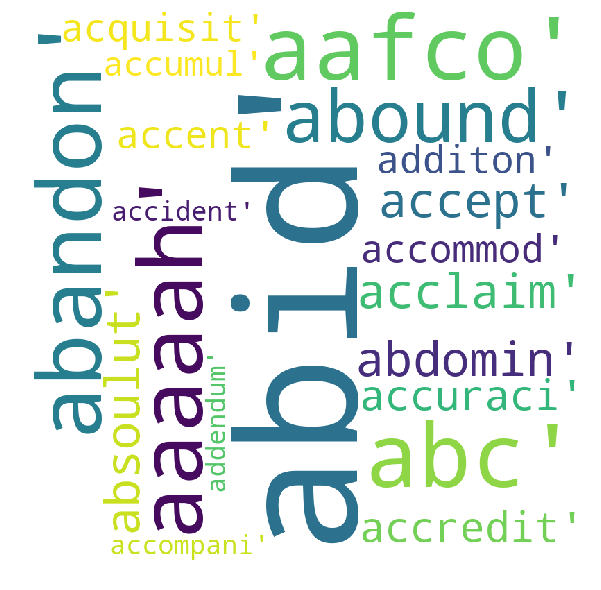

Cluster 10:


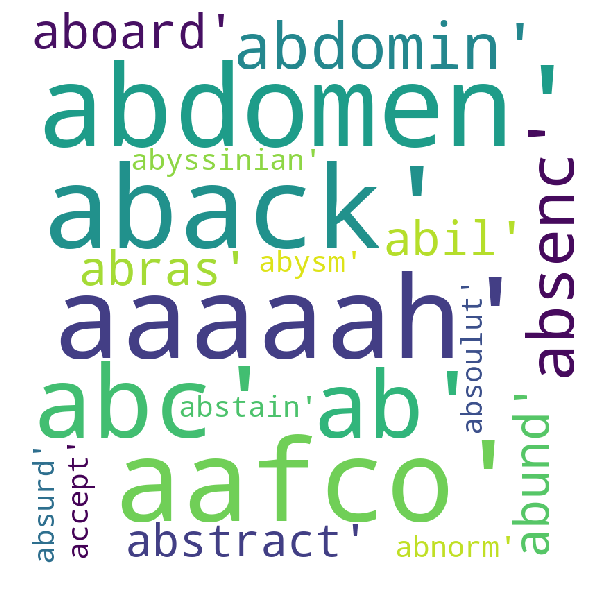

Cluster 11:


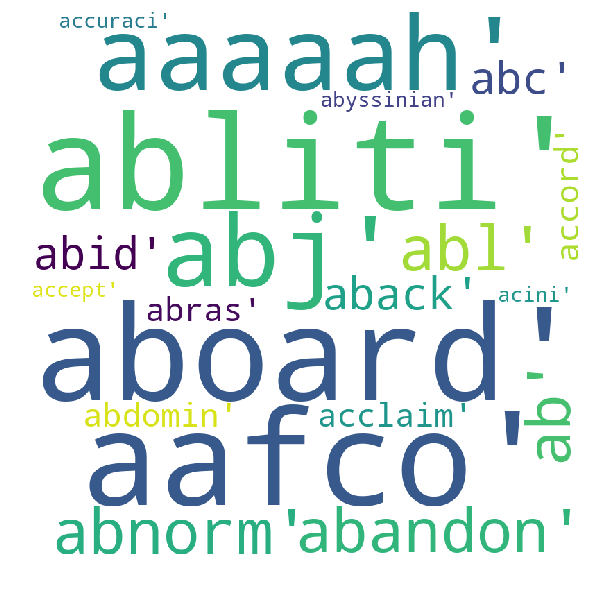

Cluster 12:


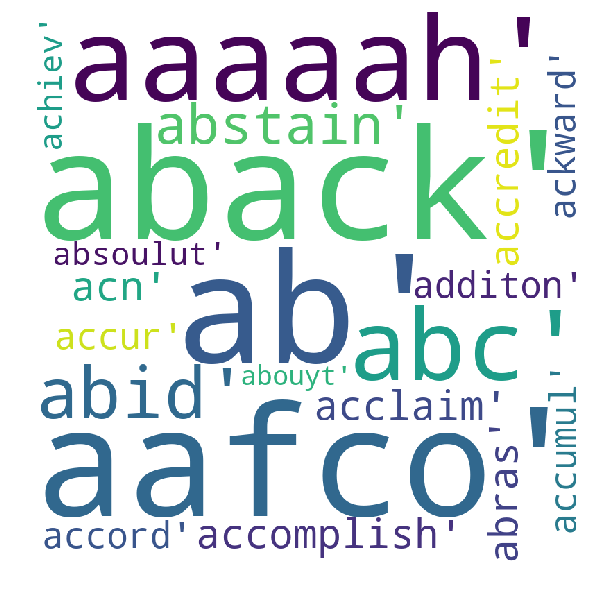

Cluster 13:


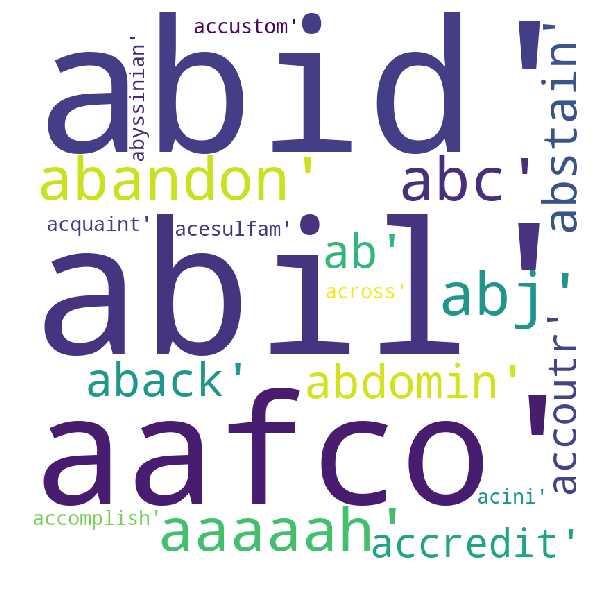

Cluster 14:


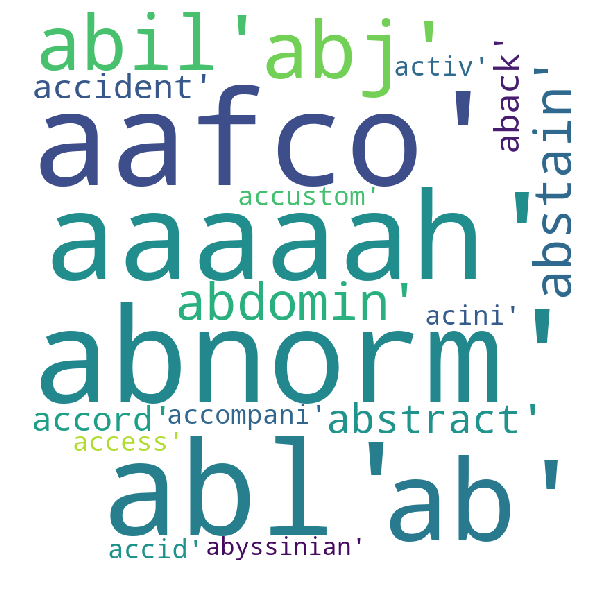

In [88]:
from wordcloud import WordCloud

terms = count_vect.get_feature_names()
for i in range(15):
    tfidf_features_arr=[]
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        
        tfidf_features_arr.append(terms[ind])
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(str(tfidf_features_arr)) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

In [0]:
similar_words=[]
def similarity(word):
  sim = cosine_similarity(co_occ)
  sim_arr = sim[word2tfidf_sorted_2000.index(word)]
  index = sim_arr.argsort()[::-1][1:5]
  for j in range(len(index)):
        similar_words.append(word2tfidf_sorted_2000[index[j]])
  print("five similar words to %s are %s "%(word,tuple(similar_words)))

In [90]:
similarity(word2tfidf_sorted_2000[0])

five similar words to rêveri are ('fulfil', 'euro', 'eurogroc', 'europ') 


#Conclusion
1. we have used truncated SVD to bring down the dimension of data set and we observed using elbow method that using 150 dimension we can explain maximum variance 
   after that % variance explained is increasing very slow.
2. We have applied Kmeans algorithm for clustering and printed word cloud.
3. We have also find similarity of word "rêveri" using cosine similarity